In [1]:
import numpy as np
from matplotlib import pyplot as plt
from dataclasses import dataclass
from echospec.utils.parameters import Parameters
from echospec.experiments.spectroscopy_vs_amplitude import AmplitudeSweepSpectroscopy, OptionsSpectroscopy2d
from echospec.utils.units import Units as u

1.99999980000002e-05


Amplitude sweep:   0%|          | 0/51 [00:00<?, ?Ω/s]

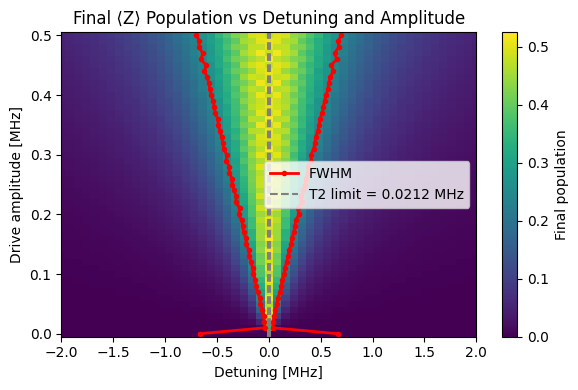

In [2]:
options = OptionsSpectroscopy2d(plot=True)
options.num_time_points = 5000
params = Parameters()
params.eco_pulse = False
params.pulse_length = 60*u.us
params.cutoff = 0.99
# params.detuning = 0.1*u.MHz*2*np.pi


detunings = np.linspace(-2, 2, 51)*2*np.pi*u.MHz
amplitudes = np.linspace(0, 0.50, 51)*2*np.pi*u.MHz
spectroscopy = AmplitudeSweepSpectroscopy(
    amplitudes=amplitudes,
    detunings=detunings,
    params=params,
    options=options
)

results = spectroscopy.run()

In [3]:
ts = results.coords["time"].values
detunings = results.coords["detuning"].values/2/np.pi/u.MHz# in MHz
amplitudes = results.coords["amplitude"].values/2/np.pi/u.MHz  # in MHz
# final_x = results.sel(observable="z").isel(time=-1)



interactive(children=(IntSlider(value=50, description='Detuning', max=50), IntSlider(value=0, description='Amp…

<function __main__.update(detuning_index, amplitude_index) -> None>

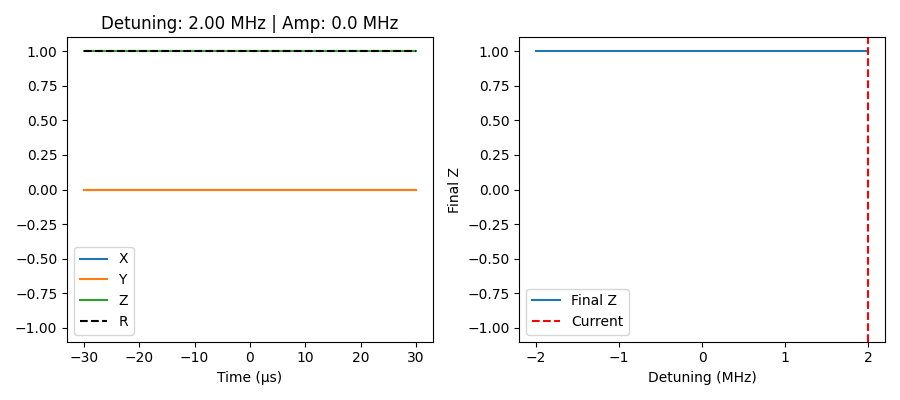

In [4]:
%matplotlib ipympl
from ipywidgets import interact, IntSlider

fig, axs = plt.subplots(1, 2, figsize=(9, 4))

det_idx0 = 50
amp_idx0 = 0

x0 = results.sel(observable="x").isel(amplitude=amp_idx0, detuning=det_idx0)
y0 = results.sel(observable="y").isel(amplitude=amp_idx0, detuning=det_idx0)
z0 = results.sel(observable="z").isel(amplitude=amp_idx0, detuning=det_idx0)
r0 = np.sqrt(x0**2 + y0**2 + z0**2)

ax = axs[0]
(line_x,) = ax.plot(ts * 1e6, x0, label="X")
(line_y,) = ax.plot(ts * 1e6, y0, label="Y")
(line_z,) = ax.plot(ts * 1e6, z0, label="Z")
(line_r,) = ax.plot(ts * 1e6, r0, "--", color="black", label="R")

ax.set_xlabel("Time (µs)")
ax.legend()
ax.set_ylim(-1.1, 1.1)
title = ax.set_title(f"Detuning: {detunings[det_idx0]:.2f} MHz | Amp: {amplitudes[amp_idx0]:.1f} MHz")

# final Z at end of pulse
final_z = results.sel(observable="z").isel(time=-1)

ax2 = axs[1]
(spec_line,) = ax2.plot(detunings, final_z.isel(amplitude=amp_idx0), label="Final Z")
vline = ax2.axvline(detunings[det_idx0], color="red", linestyle="--", label="Current")
ax2.set_xlabel("Detuning (MHz)")
ax2.set_ylabel("Final Z")
ax2.legend()
ax2.set_ylim(-1.1, 1.1)

fig.tight_layout()
fig.canvas.draw_idle()

def update(detuning_index, amplitude_index) -> None:
    x = results.sel(observable="x").isel(amplitude=amplitude_index, detuning=detuning_index)
    y = results.sel(observable="y").isel(amplitude=amplitude_index, detuning=detuning_index)
    z = results.sel(observable="z").isel(amplitude=amplitude_index, detuning=detuning_index)
    r = np.sqrt(x**2 + y**2 + z**2)

    line_x.set_ydata(x.values)
    line_y.set_ydata(y.values)
    line_z.set_ydata(z.values)
    line_r.set_ydata(r.values)

    title.set_text(
        f"Detuning: {detunings[detuning_index]:.2f} MHz | Amp: {amplitudes[amplitude_index]:.1f} MHz"
    )

    spec_line.set_ydata(final_z.isel(amplitude=amplitude_index).values)
    vline.set_xdata([detunings[detuning_index]])

    fig.canvas.draw_idle()

interact(
    update,
    detuning_index=IntSlider(min=0, max=len(detunings) - 1, step=1, value=det_idx0, description="Detuning"),
    amplitude_index=IntSlider(min=0, max=len(amplitudes) - 1, step=1, value=amp_idx0, description="Amplitude"),
)
